# load evaluation data

In [36]:
import json

def load_responses(path):
    data = []
    
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
            
    return data



In [44]:
from glob import glob
import pandas as pd


res_files = glob('data/eval3/*.json')

res_df_list = []

for f in res_files:
    model_name = f.split('/')[-1].replace(".json", "")
    correct = 0
    sra = 0
    resps = load_responses(f)
    for r in resps:
        if r['strategy'] == r['inferred_strategy']:
            correct += 1
        sra += r['sra']
    res_df_list.append({
        'acc': correct/len(resps),
        'model': model_name,
        'sra': sra/len(resps)
    })

df = pd.DataFrame(res_df_list)
df.sort_values(by=['sra'])

,acc,model,sra
1,0.144,llama2_standard,0.000862
0,0.178,llama2_c5hf,0.001212
2,0.202,llama2_c5hl,0.001270
4,0.295,llama2_c3hl,0.001658
6,0.294,llama2_c3hf,0.001776
7,0.715,llama2_c1hl,0.002231
3,0.933,llama2_ft,0.002264
5,0.765,llama2_c1hf,0.002297


# visualization of correlations and metrics

In [38]:
import numpy as np

np.corrcoef(df['acc'], df['sra'])

array([[1.        , 0.79550683],
       [0.79550683, 1.        ]])

/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

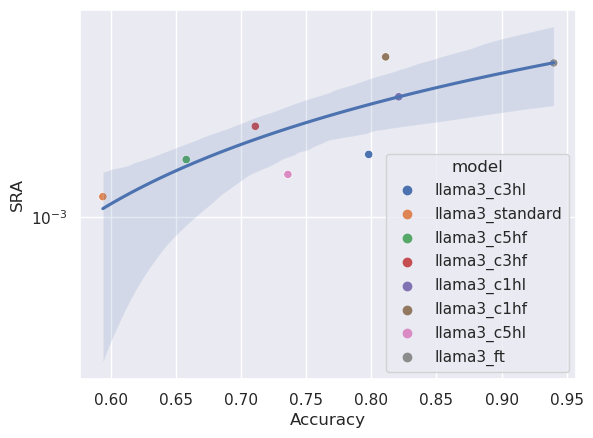

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


sns.scatterplot(df, x='acc', y='sra', hue='model')
sns.regplot(df, x='acc', y='sra', scatter=False)

# for i, row in df.iterrows():
#     plt.text(row['acc'], row['sra'], row['model'])

plt.ylabel('SRA')
plt.xlabel("Accuracy")
plt.yscale('log')

In [5]:
import pickle

with open('../prompting/outputs/mistral7b_full/109_attentions.pkl', 'rb') as f:
    a = pickle.load(f)

In [6]:
t = a['Clarification']
len(t), t[0].shape, len(t[1])

(2, torch.Size([623]), 23)

In [7]:
t[1][2].shape

torch.Size([603])

In [40]:
from glob import glob
import pandas as pd


res_files = glob('data/eval4/*.json')

res_df_list = []

for f in res_files:
    model_name = f.split('/')[-1].replace(".json", "")
    correct = 0
    sra = 0
    resps = load_responses(f)
    print("no of instances:", len(resps))
    
    for r in resps:
        if r['strategy'] == r['inferred_strategy']:
            correct = 1
        else:
            correct = 0
        res_df_list.append({
            'correct': correct,
            'turns': len(r['messages']),
            'model': model_name,
            'sra': r['sra']
        })

df = pd.DataFrame(res_df_list)
df.sort_values(by=['sra'])

no of instances: 1000
no of instances: 1000
no of instances: 1000
no of instances: 1000
no of instances: 1000
no of instances: 1000
no of instances: 1000
no of instances: 1000


,correct,turns,model,sra
1633,1,25,llama3_standard,0.000135
1097,0,19,llama3_standard,0.000147
1998,0,25,llama3_standard,0.000162
6633,0,25,llama3_c5hl,0.000184
6097,0,19,llama3_c5hl,0.000194
...,...,...,...,...
3106,0,17,llama3_c3hf,0.008099
5504,1,9,llama3_c1hf,0.008148
2106,1,17,llama3_c5hf,0.008264
5522,1,19,llama3_c1hf,0.008874


/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

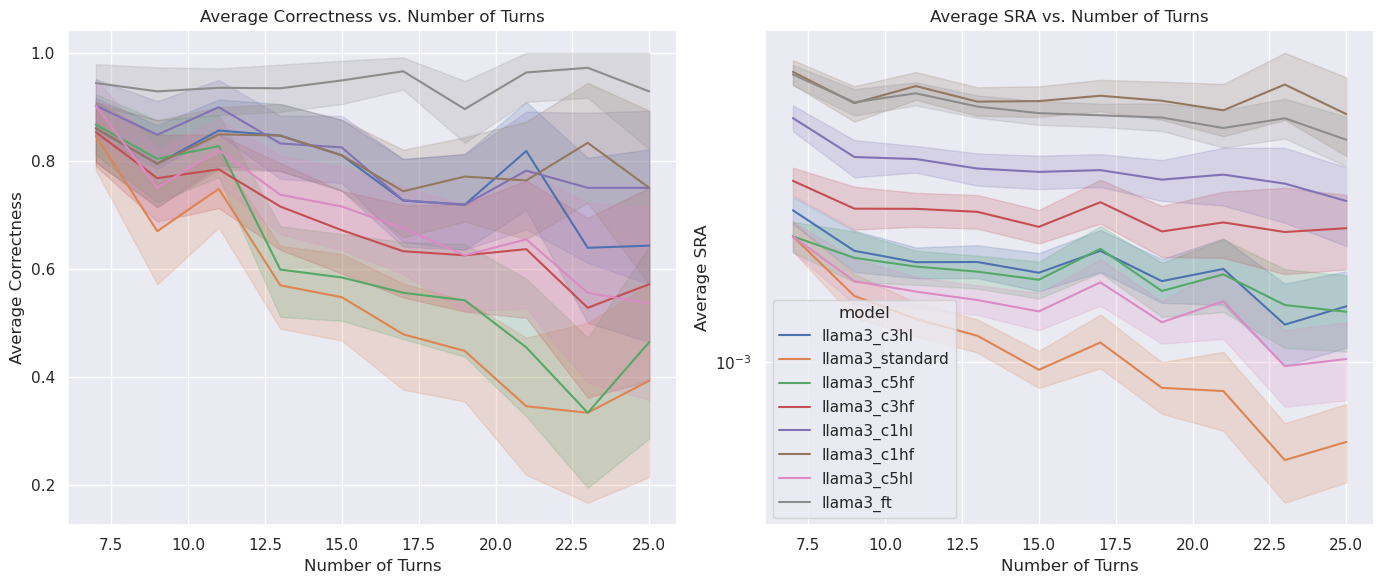

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate average correctness and SRA for each model and number of turns
avg_correctness = df.groupby(['model', 'turns'])['correct'].mean().reset_index()
avg_sra = df.groupby(['model', 'turns'])['sra'].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot average correctness vs. number of turns
sns.lineplot(x='turns', y='correct', hue='model', data=df, ax=axes[0])
axes[0].set_title('Average Correctness vs. Number of Turns')
axes[0].set_ylabel('Average Correctness')
axes[0].set_xlabel('Number of Turns')
axes[0].legend([], [], frameon=False)
# Plot average SRA vs. number of turns
sns.lineplot(x='turns', y='sra', hue='model', data=df, ax=axes[1])
axes[1].set_title('Average SRA vs. Number of Turns')
axes[1].set_ylabel('Average SRA')
axes[1].set_xlabel('Number of Turns')
axes[1].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()


# model based evaluation

In [1]:
import json
from typing import List, Dict
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.dataset import EvaluationDataset
from deepeval.metrics import GEval, BaseMetric, BiasMetric
from deepeval.utils import set_should_ignore_errors
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from deepeval import evaluate

import torch

/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/deepeval/confident/types.py:7: RuntimeWarning: fields may not start with an underscore, ignoring "_dataset_rank"
  class ConfidentEvaluateRequestData(BaseModel):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/deepeval/confident/types.py:7: RuntimeWarning: fields may not start with an underscore, ignoring "_dataset_alias"
  class ConfidentEvaluateRequestData(BaseModel):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/deepeval/confident/types.py:7: RuntimeWarning: fields may not start with an underscore, ignoring "_dataset_id"
  class ConfidentEvaluateRequestData(BaseModel):


In [52]:
import json

test_file = 'data/eval4/llama3_ft.json'

def load_jsonl(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))

    return data

data = load_jsonl(test_file)

In [53]:
import numpy as np

np.random.shuffle(data)
# data = [d for d in data if d['inferred_strategy'] != d['strategy']]
print(len(data))
with open('../annotation/strategy_classification/annotation.json', 'w') as f:
    json.dump(data[:100], f)

1000


In [58]:
from sklearn.metrics import precision_recall_fscore_support

# Extract predicted strategies and true labels
preds = [d['inferred_strategy'] for d in data]
labels = [d['strategy'] for d in data]

# Get the precision, recall, F1-score, and support for each class (strategy)
precision, recall, f1_score, support = precision_recall_fscore_support(y_true=labels, y_pred=preds)

# Get unique strategies (classes)
unique_strategies = sorted(set(labels))

# Print the precision and recall for each strategy
for i, strategy in enumerate(unique_strategies):
    print(f"Strategy: {strategy}")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1_score[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()


Strategy: Affirmation
  Precision: 0.99
  Recall: 1.00
  F1-Score: 0.99
  Support: 74

Strategy: Avoid Judgment and Criticism
  Precision: 0.75
  Recall: 0.92
  F1-Score: 0.83
  Support: 62

Strategy: Chit Chat
  Precision: 0.91
  Recall: 1.00
  F1-Score: 0.95
  Support: 63

Strategy: Clarification
  Precision: 0.98
  Recall: 0.82
  F1-Score: 0.90
  Support: 57

Strategy: Collaborative Planning
  Precision: 0.96
  Recall: 0.99
  F1-Score: 0.97
  Support: 75

Strategy: Emotional Validation
  Precision: 0.98
  Recall: 0.97
  F1-Score: 0.98
  Support: 65

Strategy: Normalize Experiences
  Precision: 0.91
  Recall: 0.98
  F1-Score: 0.95
  Support: 54

Strategy: Offer Hope
  Precision: 0.97
  Recall: 0.94
  F1-Score: 0.95
  Support: 63

Strategy: Promote Self-Care Practices
  Precision: 0.97
  Recall: 1.00
  F1-Score: 0.99
  Support: 72

Strategy: Provide Different Perspectives
  Precision: 0.96
  Recall: 0.96
  F1-Score: 0.96
  Support: 67

Strategy: Reflective Statements
  Precision: 0.90

In [14]:
def build_test_case(examples):
    test_cases = []
    instructions = []
    for ex in examples:
        # removing system message and last supporter message
        all_messages = [m['content'] for m in ex['messages']]
        messages = all_messages[1:-1]

        sys_msg_instructions = all_messages[0]
 
        case = LLMTestCase(
            input = messages[-1],
            context = messages[:-1],
            actual_output = ex['model_response']
        )
        instructions.append(sys_msg_instructions)
        test_cases.append(case)


    return test_cases, instructions

In [15]:
test_data, instructions = build_test_case(data)
test_dataset = EvaluationDataset(test_data)

In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct')

tokenizer("Hello all", add_special_tokens=False), tokenizer("bye Hello all", add_special_tokens=False)

({'input_ids': [9906, 682], 'attention_mask': [1, 1]},
 {'input_ids': [29474, 22691, 682], 'attention_mask': [1, 1, 1]})

In [27]:
tokens = tokenizer.convert_ids_to_tokens([9906, 682])
tokenizer.convert_tokens_to_string(tokens)

'Hello all'

In [28]:
tokens = tokenizer.convert_ids_to_tokens([22691, 682])
tokenizer.convert_tokens_to_string(tokens)

' Hello all'

In [35]:
def longest_common_subarray_in_first(arr1, arr2):
    n, m = len(arr1), len(arr2)
    # Create a 2D table to store lengths of longest common suffixes of substrings.
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    
    # Length of the longest common subarray
    longest_length = 0
    
    # To store the ending index of the longest common subarray in arr1
    end_index_arr1 = -1

    # Building the DP table
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if arr1[i - 1] == arr2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
                if dp[i][j] > longest_length:
                    longest_length = dp[i][j]
                    end_index_arr1 = i - 1
    
    # If no common subarray found, return None
    if longest_length == 0:
        return None

    # Calculate the start index based on the length of the longest common subarray
    start_index_arr1 = end_index_arr1 - longest_length + 1

    return (start_index_arr1, end_index_arr1)

# Example usage:
arr1 = [1, 2, 3, 2, 1, 7]
arr2 = [7, 3, 2, 1, 4, 7]

print(longest_common_subarray_in_first(arr1, arr2))


(2, 4)
